# Correlation matrices

In [3]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp


# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase
from data_processing import bins_per_trial
from timescale_functions import cov_stats, shuffle_covariance

one = ONE()

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmpxcgebhxs/cache.zip Bytes: 115043927


100%|██████████| 109.71443843841553/109.71443843841553 [00:37<00:00,  2.94it/s]


## Parameters

In [4]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [12]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]
    
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    
    # Keep only first 90 trials
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [13]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

## Trial bins

In [15]:
new_df = bins_per_trial(design_matrix, session_trials)


In [16]:
# Very hacky code to get biased left, right and unbiased with equal amounts of data (keep only 56 trials (or 1900 bins))
new_df['use_block'] = new_df['block'] * np.nan 
# new_df.loc[(new_df['Trial']>100) & (new_df['Trial']<200) & (new_df['block']==0.2), 'use_block'] = 0.2
new_df.loc[(new_df['Trial']>350) & (new_df['Trial']<440) & (new_df['block']==0.2), 'use_block'] = 0.2
new_df.loc[new_df['block']==0.5, 'use_block'] = 0.5
new_df.loc[(new_df['Trial']>280) & (new_df['Trial']<400) & (new_df['block']==0.8), 'use_block'] = 0.8
# new_df.loc[(new_df['Trial']>500) & (new_df['block']==0.8), 'use_block'] = 0.8

# Find edges of blocks
trial_init_50 = list(new_df.loc[new_df['use_block']==0.5, 'Bin'])[0]
trial_end_50 =  list(new_df.loc[new_df['use_block']==0.5, 'Bin'])[-1]
trial_init_20 = list(new_df.loc[new_df['use_block']==0.2, 'Bin'])[0]
trial_end_20 =  list(new_df.loc[new_df['use_block']==0.2, 'Bin'])[-1]
trial_init_80 = list(new_df.loc[new_df['use_block']==0.8, 'Bin'])[0]
trial_end_80 = list(new_df.loc[new_df['use_block']==0.8, 'Bin'])[-1]

# # Reduce blocks to minimum common mulltiple
# mcm = 2783.0
# new_df.loc[(new_df['block']==0.5) & (new_df['Bin']>trial_init_50+mcm), 'use_block'] = np.nan
# new_df.loc[(new_df['block']==0.2) & (new_df['Bin']>trial_init_20+mcm), 'use_block'] = np.nan
# new_df.loc[(new_df['block']==0.8) & (new_df['Bin']>trial_init_80+mcm), 'use_block'] = np.nan


In [17]:
# Reduce blocks to minimum common mulltiple
mcm = 2816.0
new_df.loc[(new_df['block']==0.5) & (new_df['Bin']>trial_init_50+mcm), 'use_block'] = np.nan
new_df.loc[(new_df['block']==0.2) & (new_df['Bin']>trial_init_20+mcm), 'use_block'] = np.nan
new_df.loc[(new_df['block']==0.8) & (new_df['Bin']>trial_init_80+mcm), 'use_block'] = np.nan

## Plot correlation matrix

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


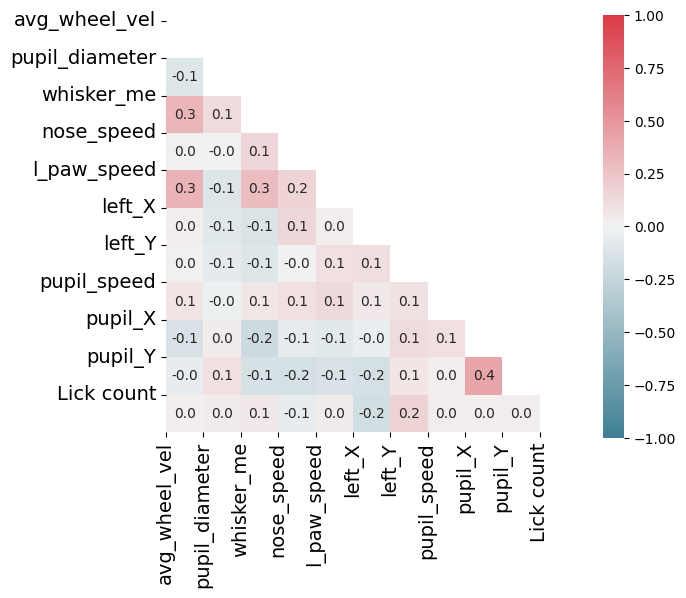

In [187]:
# Session correlation matrix
shuffle_iters = 100
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']


fig, ax = plt.subplots(figsize=[7, 6])
plt.rc('font', size=10)

# Raw data
cov_df = use_data[var_names].dropna().drop_duplicates()
cov = cov_df.corr()

# Shuffled data
shuffle_cov = shuffle_covariance (shuffle_iters, use_data, features)

# Significantly correlated
p_values, dif_cov, dif_sig_cov = cov_stats(cov, shuffle_cov, features)

# Plot
matrix = np.triu(dif_sig_cov)
sns.heatmap(dif_sig_cov,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0, fmt=".1f",
    square=True, annot=True, mask=matrix)
plt.yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
plt.xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
plt.tight_layout()
plt.show()

## Plot correlation matrix per task phase

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


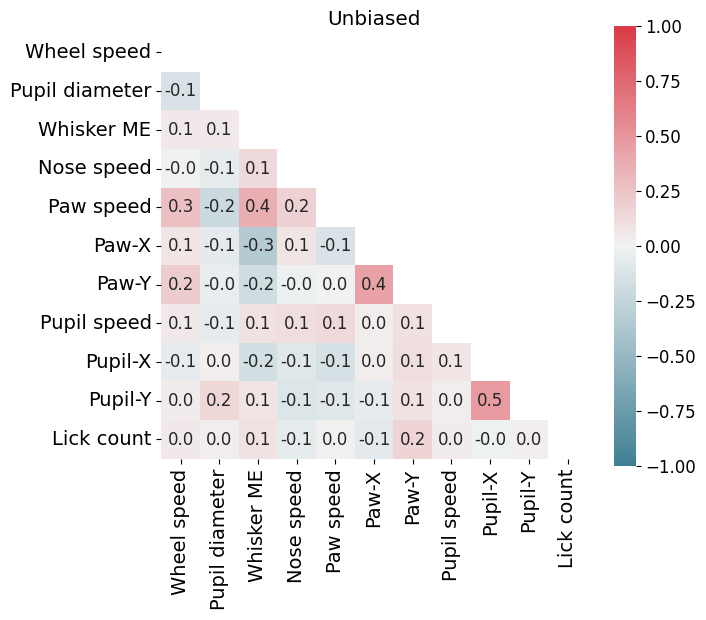

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


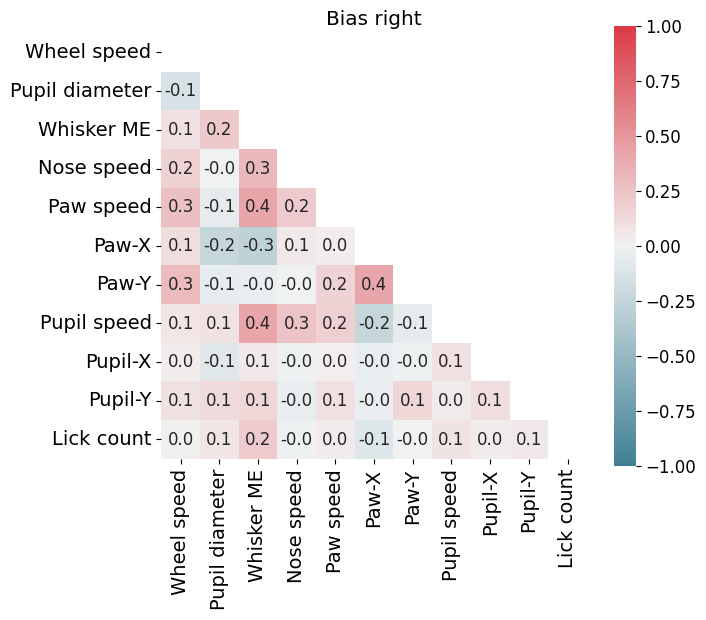

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


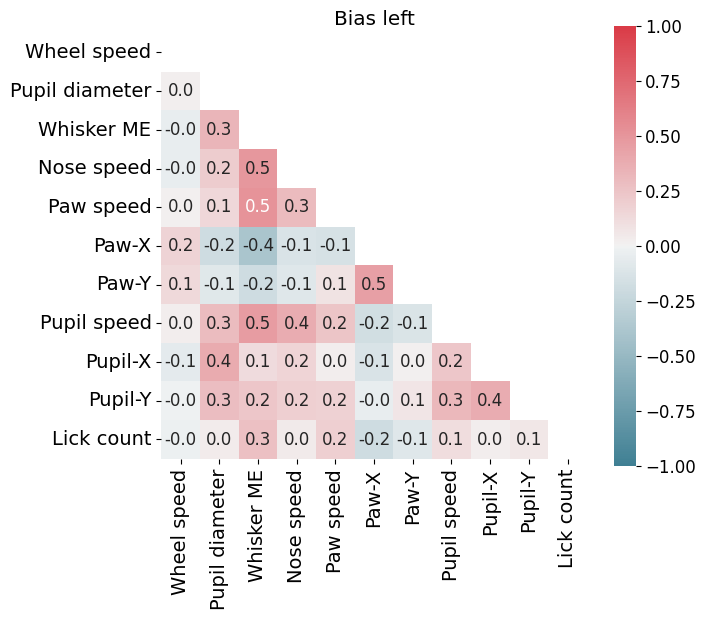

In [26]:
shuffle_iters = 100
features = ['avg_wheel_vel', 'pupil_diameter',
            'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
            'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
feature_labels = ['Wheel speed', 'Pupil diameter',
              'Whisker ME', 'Nose speed', 'Paw speed', 'Paw-X', 'Paw-Y',
              'Pupil speed', 'Pupil-X', 'Pupil-Y', 'Lick count']
blocks = [0.5, 0.2, 0.8]
block_colors = ['blue', 'red', 'green']
block_labels = ['Unbiased', 'Bias right', 'Bias left']

    
for b, block in enumerate(blocks):    
    # Session correlation matrix

    fig, ax = plt.subplots(figsize=[7.2, 6.2])
    plt.rc('font', size=12)

    # Raw data
    use = new_df.loc[new_df['use_block']==block]
    cov_df = use[features].dropna().drop_duplicates()
    cov = cov_df.corr()

    # Shuffled data
    shuffle_cov = shuffle_covariance (shuffle_iters, use_data, features)

    # Significantly correlated
    p_values, dif_cov, dif_sig_cov = cov_stats(cov, shuffle_cov, features)

    # Plot
    matrix = np.triu(dif_sig_cov)
    sns.heatmap(dif_sig_cov,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0, fmt=".1f",
        square=True, annot=True, mask=matrix)
    plt.yticks(np.arange(.5, len(feature_labels), 1), feature_labels, fontsize=14)
    plt.xticks(np.arange(.5, len(feature_labels), 1), feature_labels, fontsize=14)
    plt.title(block_labels[b])
    plt.tight_layout()
    plt.show()

## Trial phase

In [188]:
bins_df = bins_per_trial_phase(design_matrix, session_trials)
bins_df = bins_df.rename(columns={0: 'Bin'})
new_df = design_matrix.merge(bins_df, on='Bin')
melted = pd.melt(new_df, id_vars=['Bin', 'label', 'Trial'], value_vars=np.array(new_df.keys()[1:-1]))

/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:410: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:412: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/Users/ineslaranjeira/Documents/Repositories/representation_learnin

## Auto-correlation per trial phase

In [189]:
new_df['broader_label'] = new_df['label']
new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

new_df['Lick count'] = gaussian_filter1d(new_df['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
new_df['avg_wheel_vel'] = np.abs(new_df['avg_wheel_vel'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_49920/1676161104.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cov = cov_df.corr()
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_49920/1676161104.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cov = cov_df.corr()
/opt/anaconda3/envs/iblenv/lib/python3.10/site-pa

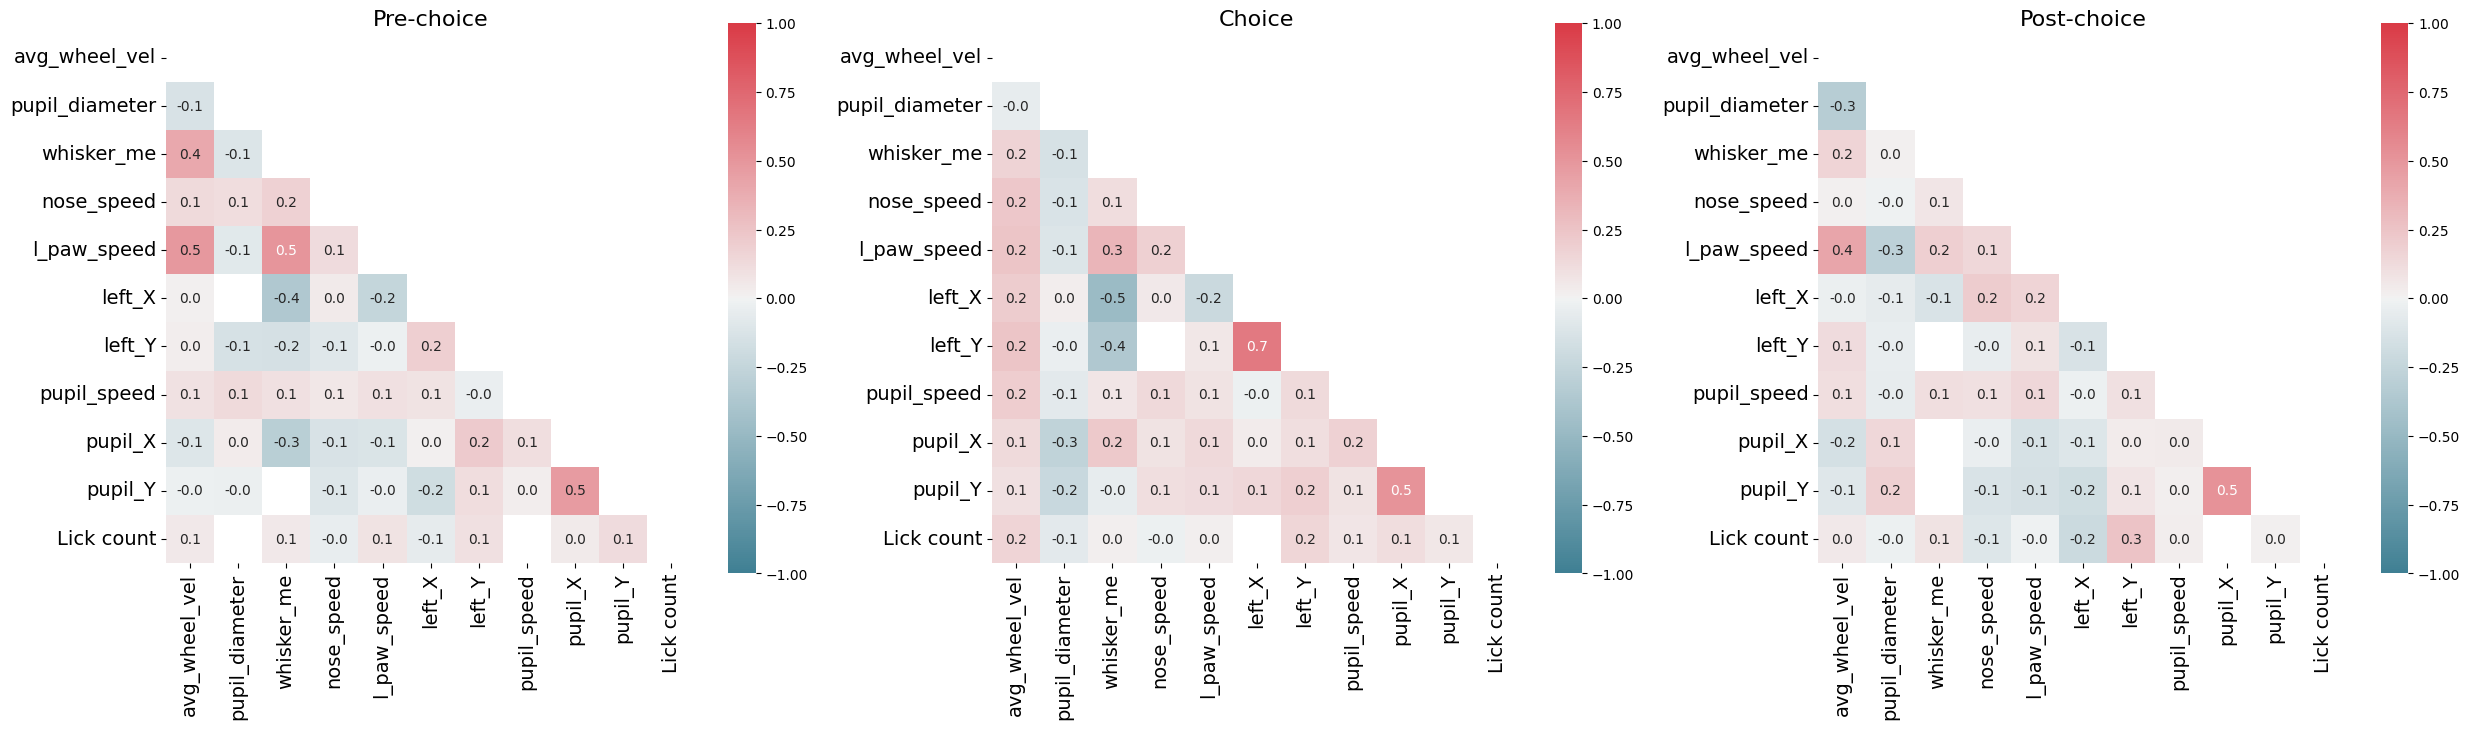

In [190]:
epoch_type = 'broader_label'  # 'broader_label'
trial_epochs = new_df[epoch_type].unique()

fig, ax = plt.subplots(nrows=1, ncols=len(trial_epochs) , sharex=False, sharey=False, figsize=[25, 7])
plt.rc('font', size=10)

for v, epoch in enumerate(trial_epochs):
    
    use_data = new_df.loc[new_df[epoch_type]==epoch]

    # Raw data
    cov_df = use_data[var_names].dropna().drop_duplicates()
    cov = cov_df.corr()

    # Shuffled data
    shuffle_cov = shuffle_covariance (shuffle_iters, use_data, features)

    # Significantly correlated
    p_values, dif_cov, dif_sig_cov = cov_stats(cov, shuffle_cov, features)

    # f = ax[v].figure(figsize=(10, 11))
    ax[v].set_xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
    ax[v].set_yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
    ax[v].set_title(str(epoch), fontsize=16)

    matrix = np.triu(dif_sig_cov)

    sns.heatmap(dif_sig_cov,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0, fmt=".1f",
        square=True, annot=True, mask=matrix, ax=ax[v])

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


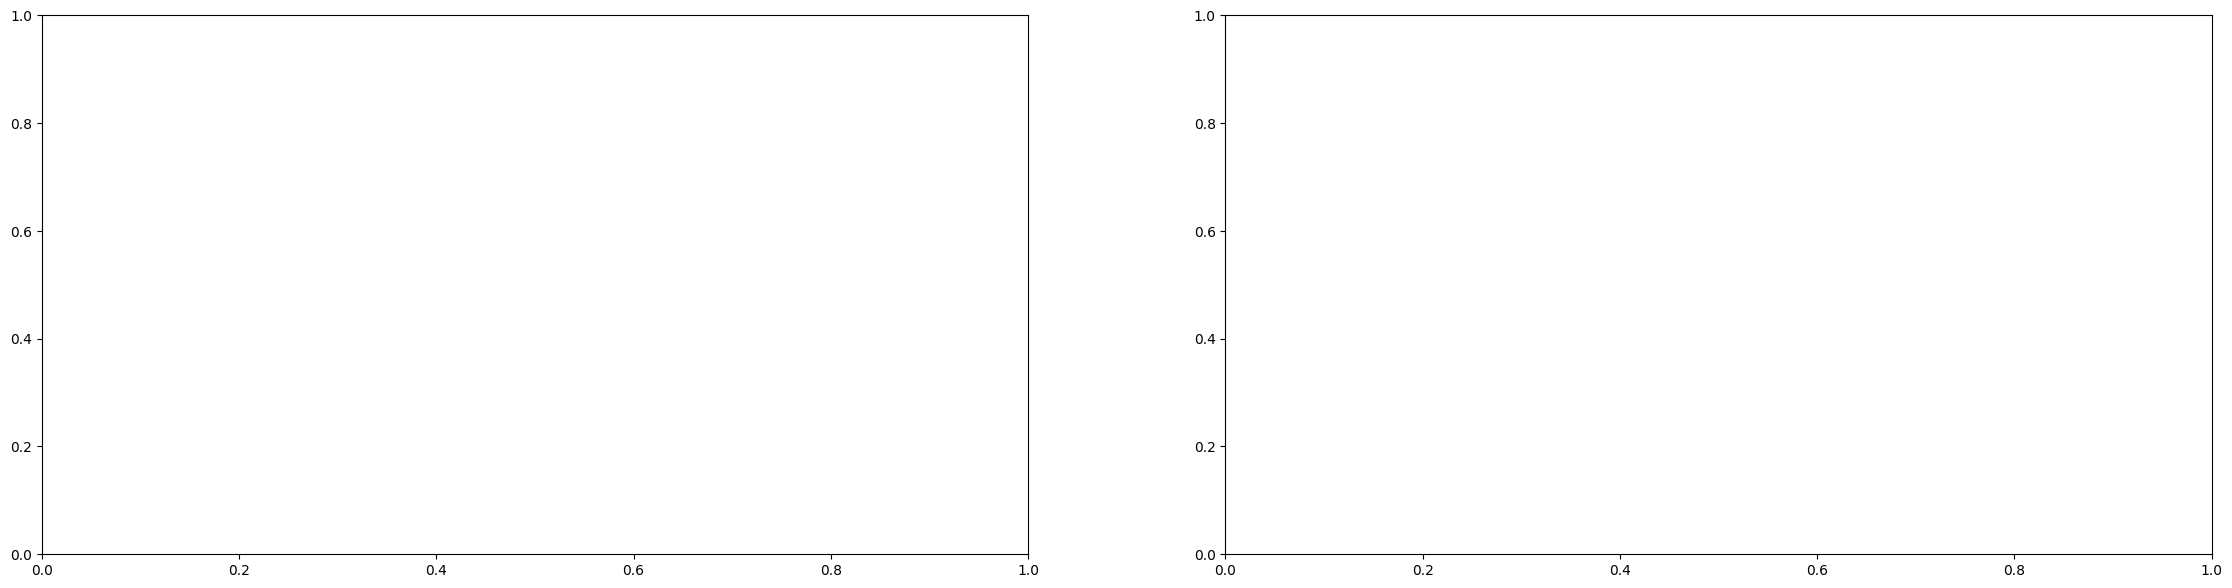

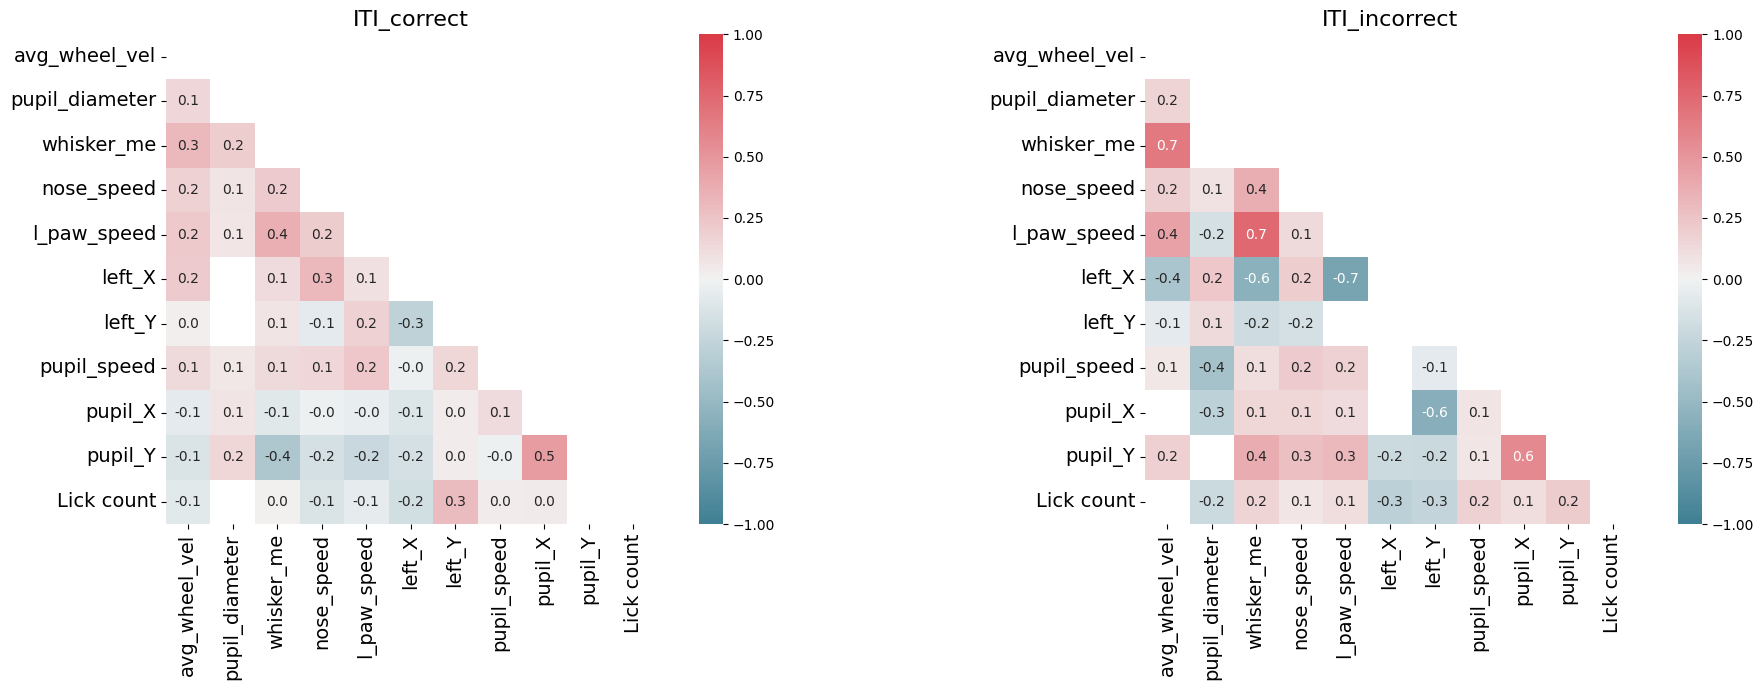

In [195]:
trial_epochs = new_df['label'].unique()
trial_epochs = ['ITI_correct', 'ITI_incorrect']
# trial_epochs = ['Correct feedback', 'Incorrect feedback']
# trial_epochs = ['Quiescence', 'Stimulus left', 'Stimulus right']
# trial_epochs = ['Right choice', 'Left choice']


# fig, ax = plt.subplots(nrows=1, ncols=len(trial_epochs) , sharex=False, sharey=False, figsize=[28, 7])
fig, ax = plt.subplots(nrows=1, ncols=len(trial_epochs) , sharex=False, sharey=False, figsize=[20, 7])

plt.rc('font', size=10)

for v, epoch in enumerate(trial_epochs):
    
    use_data = new_df.loc[new_df['label']==epoch]

    # Raw data
    cov_df = use_data[var_names].dropna().drop_duplicates()
    cov = cov_df.corr()

    # Shuffled data
    shuffle_cov = shuffle_covariance (shuffle_iters, cov_df, features)

    # Significantly correlated
    p_values, dif_cov, dif_sig_cov = cov_stats(cov, shuffle_cov, features)

    # f = ax[v].figure(figsize=(10, 11))
    ax[v].set_xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
    ax[v].set_yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
    ax[v].set_title(str(epoch), fontsize=16)

    matrix = np.triu(dif_sig_cov)

    sns.heatmap(dif_sig_cov,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0, fmt=".1f",
        square=True, annot=True, mask=matrix, ax=ax[v])

plt.tight_layout()
plt.show()

True